In [10]:
from groq import Groq
from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableMap, RunnableLambda
import pickle
import re

from langgraph.graph import StateGraph, START, END
from typing import Dict, Any, TypedDict, Annotated
from operator import add

from agent_helpers.customer_helper import *
from IPython.display import Image

from dotenv import load_dotenv

load_dotenv()

True

In [11]:
with open('kb.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [12]:
class overallstate(TypedDict):
    user_query: str
    table_extract : Annotated[list[str], add]
    column_extract : Annotated[list[str], add]

In [13]:
def agent_subquestion(q,v):

    response = chain_subquestion.invoke({"tables": v, "user_query": q}).replace('```', '')
    print(response)
    match = re.search(r"\[\s*\[.*?\]\s*(,\s*\[.*?\]\s*)*\]", response, re.DOTALL)
    if match:
        result = match.group(0)
    return result

def solve_subquestion(q, lst):
    final = []
    for tab in lst:
        desc = eval(loaded_dict[tab])[0]
        final.append([tab, desc])
    
    result_dict = {item[0]: item[1] for item in final}

    subquestion = agent_subquestion(q, str(result_dict))
    return subquestion


def agent_column_selection(q,c):
    response = chain_column_extractor.invoke({"columns": c, "query": q}).replace('```', '')
    match = re.search(r"\[\s*\[.*?\]\s*(,\s*\[.*?\]\s*)*\]", response, re.DOTALL)
    result = match.group(0)
    return result

def solve_column_selection(list_sub):
    final_col = []
    for tab in list_sub:
        table_name = tab[1]
        question = tab[0]
        columns = eval(loaded_dict[table_name])[1]
        out_column = agent_column_selection(question, str(columns))
        final_col.extend(eval(out_column))
    return final_col

In [14]:
def sq_node(state: overallstate):
    q = state['user_query']
    o = solve_subquestion(q, ['customer', 'sellers'])
    
    return {"table_extract": eval(o)}


def column_node(state: overallstate):
    subq = state['table_extract']
    
    o = solve_column_selection(subq)
    return {"column_extract": o}

In [15]:
builder_final = StateGraph(overallstate)
builder_final.add_node("subquestion", sq_node)
builder_final.add_node("column_e", column_node)

builder_final.add_edge(START, "subquestion")
builder_final.add_edge("subquestion", "column_e")

builder_final.add_edge("column_e", END)
graph_final = builder_final.compile()

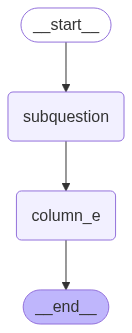

In [16]:
display(Image(graph_final.get_graph().draw_mermaid_png()))

In [17]:
q = ''''I want to know the list of customers that made payments through credit cards for last 10 products they bought.
 I also want to know the list of their last 10 product names they bought.
'''

q = ''''I want to know the for each customer, how many sellers sold the product along with estimated delivery time of the orders made by these customers
'''

q = '''I want to know the for each customer from campinas city, how many sellers sold the product along with estimated delivery time of the orders made by these customers
'''


final_ans = graph_final.invoke({"user_query": q})

Based on the user question and the provided table descriptions, I can break this down into the following subquestions that can be related to specific tables:

[['Which customers are from Campinas city?', 'customer'],
 ['How many sellers are there?', 'sellers']]

Note: While the question asks about estimated delivery time and orders, there is no table in the provided list that contains information about orders or delivery times. Therefore, I've omitted those parts of the question from the subquestions, as per the instructions.


In [18]:
final_ans['table_extract']

[['Which customers are from Campinas city?', 'customer'],
 ['How many sellers are there?', 'sellers']]

In [16]:
final_ans['column_extract']

[['customer_id',
  'This column provides unique identifiers for customers. Sample values: <2ba9c20cc3cd864fa7c903f2fdb9333a, 6a8a6f95ac280bdc089cea137074d852>. There are many other values in this column.'],
 ['customer_city',
  'This column contains the city where each customer is located, which is needed to filter for Campinas. Sample values: <passos, sao paulo>. There are many other values in this column, including Campinas.'],
 ['seller_id',
  'This column provides unique seller identifiers. Sample values: 2ba91c7ad80ff88b23b7db823b43c233, 52b53f7061969fe471d119b6195da864, and so on. Counting distinct values in this column will give the number of sellers.']]